## ベイズ線形回帰

詳細は[ベイズ線形回帰 - 理論と実装](http://2kasa.sub.jp/bayesian-linear-regression)をご覧ください。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### 1次元ガウス分布

\begin{align*}
p(x|\mu, \sigma^2) = \frac{1}{(2 \pi \sigma^2)^{1 / 2}} \left\{ - \frac{1}{2 \sigma^2} (x - \mu)^2 \right\}
\end{align*}

In [2]:
def gaussian1d_pdf(x, mean, var):
    coef = 1 / np.sqrt(2 * np.pi * var)
    return coef * np.exp(-(x - mean) ** 2 / (2 * var))

#### $\mathbf{w} \in \mathbb{R}^M$の事前分布

一般的に事前分布としてのガウス分布は以下のように表せる。

\begin{align*}
 p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_0, \mathbf{S}_0).
\end{align*}

しかしここではハイパーパラメータ$\alpha$を持つ、より単純なガウス分布を用いる。

\begin{align*}
p(\mathbf{w}|\alpha) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1} \mathbf{I}).
\end{align*}

In [3]:
def w_prior(M, alpha):
    m_0 = np.zeros(M)
    S_0 = (1 / alpha) * np.identity(M)

    return m_0, S_0

#### $\mathbf{w}$の事後分布

$\mathbf{w}$の事前分布が$p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_0, \mathbf{S}_0)$のとき、事後分布は以下のように表される。

\begin{align*}
p(\mathbf{w}|\mathrm{X}, \mathrm{T}, \beta) &= \mathcal{N}(\mathbf{w}|\mathbf{m}_N, \mathbf{S}_N)
\end{align*}

ここで$\mathbf{m}_N, \mathbf{S}_N$は

\begin{align*}
\mathbf{m}_N &= \mathbf{S}_N^{-1} \left( \mathbf{S}_0^{-1} \mathbf{m}_0 + \beta \boldsymbol{\Phi}^T \mathbf{t} \right) \\ 
\mathbf{S}_N^{-1} &= \mathbf{S}_0^{-1} + \beta \boldsymbol{\Phi}^T \boldsymbol{\Phi} 
\end{align*}

となる。

In [4]:
def w_posterior(t_data, Phi, m_0, S_0, beta):
    S_0_inv = np.linalg.inv(S_0)

    S_N = np.linalg.inv(S_0_inv + beta * np.dot(Phi.T, Phi))
    m_N = S_N.dot(S_0_inv.dot(m_0) + beta * Phi.T.dot(t_data))

    return m_N, S_N

#### $t$の予測分布

$t$の予測分布は

\begin{align*}
p(t|\mathrm{x}, \mathrm{X}, \mathrm{T}, \beta) = \mathcal{N}(t|\mathbf{m}_N^T \boldsymbol{\phi}(\mathbf{x}), \beta^{-1} + \boldsymbol{\phi}(\mathbf{x})^T \mathbf{S}_N \boldsymbol{\phi}(\mathbf{x})) 
\end{align*}

となる。

In [5]:
def t_predictive(phi, beta, m_N, S_N):
    t_mean = np.dot(m_N, phi)
    t_var = (1 / beta) + np.dot(phi, np.dot(S_N, phi))

    return t_mean, t_var

#### 学習データの生成

ランダムに学習データを生成する。
$x, t$はともに1次元とし、$t$の真の分布は$t = \sin (2 \pi x)$とする。


In [6]:
def positive_or_negative(shape):
    return np.sign(np.random.uniform(-1, 1, shape))


def generate_1d_x_and_t(N, seed=0):
    np.random.seed(seed)

    x_data = np.random.uniform(0, 1, N)

    t_true = np.sin(2 * np.pi * x_data)
    t_noise = 0.05 * np.random.normal(size=N) * positive_or_negative(N)
    t_data = t_true + t_noise

    return x_data, t_data

#### 基底関数集合

入力変数$x$が1次元と仮定して、次のような特徴ベクトル$\boldsymbol{\phi}(x) \in \mathbb{R}^{12}$に特徴変換する。

\begin{align*}
\boldsymbol{\phi}(x) = \left[1, \exp \left\{- \frac{(x + 1)^2}{ 2 \cdot (0.1)^2} \right\}, \exp \left\{- \frac{(x +0.8)^2}{ 2 \cdot (0.1)^2} \right\}, \cdots, \exp \left\{- \frac{(x - 0.8)^2}{ 2 \cdot (0.1)^2} \right\}, \exp \left\{- \frac{(x - 1)^2}{ 2 \cdot (0.1)^2} \right\} \right]^T.
\end{align*}

In [7]:
def gaussian_basis(x):
    mu = np.arange(-1, 1 + 0.2, 0.2)
    s = 0.1

    numerator = -np.square(x - mu)
    denominator = 2 * np.square(s)
    
    phi = np.append(1, np.exp(numerator / denominator))
    return phi

#### ハイパーパラメータ

\begin{align*}
\alpha = 0.1 \\
\beta = 9.0
\end{align*}
とする。

In [8]:
alpha = 0.1
beta = 9.0

#### 予測分布の動作確認

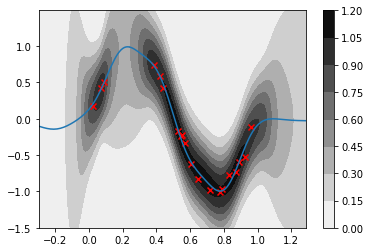

In [9]:
x_data, t_data = generate_1d_x_and_t(20)
Phi = np.array([gaussian_basis(x) for x in x_data])
M = Phi.shape[1]

# wの事前分布および事後分布
m_0, S_0 = w_prior(M, alpha)
m_N, S_N = w_posterior(t_data, Phi, m_0, S_0, beta)

# 予測分布のプロット
x_points = np.arange(-0.3, 1.3, 0.01)
t_points = np.arange(-1.5, 1.5, 0.01)
Phi_points = np.array([gaussian_basis(x) for x in x_points])
t_mean, t_var = zip(*[t_predictive(p, beta, m_N, S_N)
                      for p in Phi_points])

z = np.array([gaussian1d_pdf(t_points, tm, tv) for tm, tv in
              zip(t_mean, t_var)]).T

c = plt.contourf(x_points, t_points, z, cmap=plt.get_cmap("binary"))
plt.colorbar(c)
plt.scatter(x_data, t_data, marker="x", c="r")
plt.plot(x_points, t_mean)
plt.show()